# 1. KNN 알고리즘을 사용해 타이타닉 승객 생존여부 분류

하단의 코드 실행 (타이타닉 데이터 전처리 코드) 후 문제풀이 진행

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

df = sns.load_dataset('titanic')
df.head()
df.info()

rdf = df.drop(['deck','embark_town'], axis=1)
rdf.columns.values
rdf = rdf.dropna(subset=['age'], how='any', axis=0)
len(rdf)
rdf.info()
most_freq = rdf['embarked'].value_counts(dropna=True).idxmax()
rdf['embarked'].fillna(most_freq, inplace=True)

ndf = rdf[['survived','pclass','sex','age','sibsp','parch','embarked']]
ndf.head()

onehot_sex = pd.get_dummies(ndf['sex'])
ndf = pd.concat([ndf, onehot_sex], axis=1)

onehot_embarked = pd.get_dummies(ndf['embarked'], prefix='town') #prefix는 열 이름 접두어
ndf = pd.concat([ndf, onehot_embarked], axis=1)
ndf.drop(['sex','embarked'], axis=1, inplace =True)
print(ndf.head())

X = ndf.drop(['survived'],axis=1)
y = ndf['survived']

X = StandardScaler().fit(X).transform(X)

X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.20, random_state=5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     891 non-null    int64   
 1   pclass       891 non-null    int64   
 2   sex          891 non-null    object  
 3   age          714 non-null    float64 
 4   sibsp        891 non-null    int64   
 5   parch        891 non-null    int64   
 6   fare         891 non-null    float64 
 7   embarked     889 non-null    object  
 8   class        891 non-null    category
 9   who          891 non-null    object  
 10  adult_male   891 non-null    bool    
 11  deck         203 non-null    category
 12  embark_town  889 non-null    object  
 13  alive        891 non-null    object  
 14  alone        891 non-null    bool    
dtypes: bool(2), category(2), float64(2), int64(4), object(5)
memory usage: 80.6+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 714 entries, 0 to 890
Data co

### 1.1) GridSearchCV를 사용해 최적 파라미터를 찾아주세요

이웃 수, 거리지표, 가중치, cv 등 자유롭게 조정

In [2]:
from sklearn.model_selection import GridSearchCV

grid_params = {'n_neighbors':[], 
               'weights':[''],
               'metric':['']}


### 1.2) 1번에서 찾은 파라미터를 적용한 모델을 기반으로 분류예측을 진행 후 오차행렬과 test 정확도를 출력하세요

### 1.3)  2번에서 사용한 모델의 이웃 개수가 best인지 train 정확도와 test정확도를 이용한 시각화를 통해 확인해보세요. Best가 아닌 것으로 보인다면 파라미터를 조정한 후 다시 오차행렬과 test 정확도를 출력하세요

In [3]:
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings('ignore')
from matplotlib import font_manager, rc
font_path = "malgun.ttf"
font_name = font_manager.FontProperties(fname=font_path).get_name()
rc("font", family=font_name)

# 2. SVM 

In [4]:
def plot_svm(X, y, model, xmin=-3, xmax=3, ymin=-3, ymax=3):
    XX, YY = np.meshgrid(np.arange(xmin, xmax, (xmax-xmin)/1000),
                         np.arange(ymin, ymax, (ymax-ymin)/1000))
    ZZ = np.reshape(model.predict(
        np.array([XX.ravel(), YY.ravel()]).T), XX.shape)
    plt.contourf(XX, YY, ZZ, cmap=plt.cm.Paired_r, alpha=0.5)
    plt.scatter(X[y == 1, 0], X[y == 1, 1], c='b',
                marker='o', s=50)
    plt.scatter(X[y == 0, 0], X[y == 0, 1], c='r',
                marker='s', s=50)
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)
    plt.title("nonlinear Svm")
    plt.xlabel("x1")
    plt.ylabel("x2")

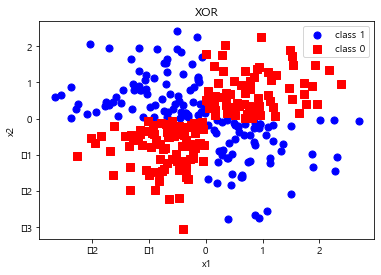

In [5]:
from sklearn.svm import SVC
import numpy as np
from sklearn.datasets import make_blobs
from matplotlib import pyplot as plt

np.random.seed(0)
X_xor = np.random.randn(300, 2)
y_xor = np.logical_xor(X_xor[:, 0] > 0, X_xor[:, 1] > 0)
y_xor = np.where(y_xor, 1, 0)
plt.scatter(X_xor[y_xor == 1, 0], X_xor[y_xor == 1, 1],
            c='b', marker='o', label='class 1', s=50)
plt.scatter(X_xor[y_xor == 0, 0], X_xor[y_xor == 0, 1],
            c='r', marker='s', label='class 0', s=50)
plt.legend()
plt.xlabel("x1")
plt.ylabel("x2")
plt.title("XOR")
plt.show()

### 2.1) 위 코드를 통해 얻은 Plot을 보고 class1과 class0를 나누기 위해 아래 3개의 kernel과 조건을 사용해 각각 코드를 실행 시키세요.
#### (1) linear 
#### (2) poly : gamma=1, coef0=0
#### (3) rbf
#### (4) sigmond: gamma=2, coef0=2

# 3. 앙상블(ensemble) 학습

### 3.1) 데이터 로드 및 선택
##### 아래 코드를 실행해주세요

In [6]:
import pandas as pd

from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings('ignore')

heart = pd.read_csv('heart_disease.csv')
heart.head(5)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


In [7]:
heart.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1025 entries, 0 to 1024
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1025 non-null   int64  
 1   sex       1025 non-null   int64  
 2   cp        1025 non-null   int64  
 3   trestbps  1025 non-null   int64  
 4   chol      1025 non-null   int64  
 5   fbs       1025 non-null   int64  
 6   restecg   1025 non-null   int64  
 7   thalach   1025 non-null   int64  
 8   exang     1025 non-null   int64  
 9   oldpeak   1025 non-null   float64
 10  slope     1025 non-null   int64  
 11  ca        1025 non-null   int64  
 12  thal      1025 non-null   int64  
 13  target    1025 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 112.2 KB


#### hear_label에 타겟 레이블 값을 저장해주시고 나머지 데이터를 heart_data에 저장해주세요.
* 타겟 레이블 데이터가 저장되어 있는 열 이름은 'target' 입니다.

### 3.2.1) 소프트 보팅/하드 보팅 비교 
* 로지스틱 회귀, KNN, 결정트리를 각각 lr_cf, knn_clf, dt_clf로 불러와주세요
* lr_cf, knn_clf, dt_clf을 모두 이용해 Soft Voting 분류기, Hard Voting 분류기를 만들어주세요
* Soft_Voting 분류기는 vo_clf_s, Hard_Voting 분류기는 vo_clf_h로 저장해주세요
* train data와 test data 분리시 test_size를 0.25로 해주시고 radom_state는 본인 생일로 해주세요
* 예시: 1999.11.22 -> random_state = 1122 / 1997.05.31 -> random_state = 531
* Soft Voting 분류기와 Hard Voting 분류기의 정확도를 각각 출력해주세요

### 3.2.2) Soft Voting 분류기와 Hard Voting 분류기 중 어떤 분류기가 더 좋은지 위의 결과를 바탕으로 성능을 비교해주세요

딥:

### 3.3.1) 개별 모형 정확도 측정
* lr_cf, knn_clf, dt_clf를 이용해 각 Clssifier별 정확도를 출력해주세요
* train data와 test data 분리시 위와 동일하게 test_size를 0.25로 해주시고 radom_state는 본인 생일로 해주세요
* 예시: 1999.11.22 -> random_state = 1122 / 1997.05.31 -> random_state = 531

### 3.3.2) 개별 분류기의 성능과 보팅 분류기의 성능을 비교해 앙상블 학습의 특징이 무엇인지 서술해주세요.

답:

# 4. 랜덤포레스트

- 랜덤포레스트는 여러개의 Decision Tree를 만들고 연결한 후, 결과를 평균 내어 성능을 높인 모델입니다.
- 4번 과제는 RandomForestClassifier로 랜덤포레스트를 하는 것이 아닌 랜덤포레스트의 원리를 이해하기 위해 Decision Tree로 직접 앙상블 해보는 것입니다.

In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

print(train.info())
print(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pcl

In [9]:
# 데이터 전처리
train['Age'] = train['Age'].fillna(train['Age'].mean())
test['Age'] = test['Age'].fillna(train['Age'].mean())

train.loc[train['Age']<10, 'Age']=0
train.loc[(train['Age']>=10) & (train['Age']<20), 'Age']=1
train.loc[(train['Age']>=20) & (train['Age']<30), 'Age']=2
train.loc[(train['Age']>=30) & (train['Age']<40), 'Age']=3
train.loc[(train['Age']>=40) & (train['Age']<50), 'Age']=4
train.loc[train['Age']>=50, 'Age']=5

test.loc[train['Age']<10, 'Age']=0
test.loc[(train['Age']>=10) & (train['Age']<20), 'Age']=1
test.loc[(train['Age']>=20) & (train['Age']<30), 'Age']=2
test.loc[(train['Age']>=30) & (train['Age']<40), 'Age']=3
test.loc[(train['Age']>=40) & (train['Age']<50), 'Age']=4
test.loc[train['Age']>=50, 'Age']=5

train['FamilySize'] = train['SibSp']+train['Parch']
test['FamilySize'] = test['SibSp']+test['Parch']

train['Fare'] = train['Fare'].fillna(train['Fare'].mean())
test['Fare'] = test['Fare'].fillna(train['Fare'].mean())

train['Embarked'] = train['Embarked'].fillna('S')
test['Embarked'] = test['Embarked'].fillna('S')
train['Embarked'] = train['Embarked'].map({
    'S' : 0, 'C' : 1, 'Q' : 2})
test['Embarked'] = test['Embarked'].map({
    'S' : 0, 'C' : 1, 'Q' : 2})

train.loc[train['Sex']=='male', 'Sex']=0
train.loc[train['Sex']=='female', 'Sex']=1
test.loc[test['Sex']=='male', 'Sex']=0
test.loc[test['Sex']=='female', 'Sex']=1

train = train[['Survived', 'Sex', 'Age', 'FamilySize', 'Fare', 'Embarked']]
test = test[['Sex', 'Age', 'FamilySize', 'Fare', 'Embarked']]

X_train = train[['Sex', 'Age', 'FamilySize', 'Fare', 'Embarked']]
y_train = train['Survived']
X_test = test

## Decision Tree로 앙상블

### 4.1) train set (X_train과 y_train)로 학습한 모델의 성능을 측정하기위해 validation set을 만듭니다.
- train set(X_train, y_train)의 앞쪽 100개만 X_valid, y_valid에 저장 해주세요.
- 앞의 100개를 제외한 남은 부분을 다시 X_train과 y_train으로 재정의 해주세요.

### 4.2) tree1, tree2, tree3에 3개의 DecisionTree를 구성하여 (1)에서 만든 X_train, y_train으로 학습해주세요. 그리고 각 tree의 train set과 validation set의 score를 출력해주세요.

- ' from sklearn.tree import DecisionTreeClassifier '를 사용하세요
- 예를 들어, tree1의 train set score는 tree1.score(X_train, y_train)으로 확인할 수 있습니다.

### 4.3) 각 tree를 X_test를 통해 예측하여 pred1, pred2, pred3에 저장해주세요. 그리고 ensemble에 pred1, pred2, pred3의 평균을 저장해주세요.

- 그 후, ensemble > 0.5이면 1로, ensemble <= 0.5이면 0으로 변환해주세요.
- 마지막으로 ensemble 변수를 int형으로 바꿔주세요.

- 예측 정확도가 궁금하시다면, ensemble을 csv파일로 내보낸 후, 'https://www.kaggle.com/c/titanic/submit' 홈페이지에 제출하면 확인 할 수 있습니다.